In [72]:

import pandas as pd 
import numpy as np
from numpy import *



import gc
import time
import warnings
import os


from datetime import datetime
from datetime import timedelta


from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from sklearn.metrics import mean_squared_error

In [73]:
#Merge info
def mergeData(df):
    features =pd.read_csv('./input/wallmart-sales-forecast-datasets/features.csv')
    storesdata =pd.read_csv('./input/wallmart-sales-forecast-datasets/stores.csv')
    df = pd.merge(df, features, on=['Store','Date','IsHoliday'],
                  how='inner')
    df = pd.merge(df, storesdata, on=['Store'],
                  how='inner')
    return df

#http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html
def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()
def binary(movement):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    direction = np.empty(movement.shape[0])
    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(movement.shape[0]):
        if movement[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction

def scatterplots(feature, label):
    x = feature
    y = df['Weekly_Sales']
    plt.scatter(x, y)
    plt.ylabel('sales')
    plt.xlabel(label)
    plt.show()

In [74]:
print('Reading data...')
print(os.listdir('./input/'))
print(os.listdir('./input/wallmart-sales-forecast-datasets'))

Reading data...
['course-material-walmart-challenge', 'course-material-walmart-challenge.zip', 'wallmart-sales-forecast-datasets']
['features.csv', 'sampleSubmission.csv', 'stores.csv', 'test.csv', 'test.xlsx', 'train.csv']


In [75]:
train = pd.read_csv('./input/course-material-walmart-challenge/train.csv')
test = pd.read_csv('./input/course-material-walmart-challenge/test.csv')
train['Split'] = 'Train'
test['Split'] = 'Test'
test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
0,28,40,2012-01-06,False,50.43,3.599,5155.86,19549.51,218.29,636.73,5218.50,130.157516,12.187,A,206302,Test
1,18,93,2012-03-09,False,38.10,3.876,7410.18,368.19,25.46,1852.39,2332.07,137.506690,8.075,B,120653,Test
2,38,4,2011-05-27,False,76.67,4.087,NaN,NaN,NaN,NaN,NaN,129.062355,13.736,C,39690,Test
3,29,33,2010-03-12,False,43.43,2.805,NaN,NaN,NaN,NaN,NaN,131.784000,10.064,B,93638,Test
4,13,52,2010-10-29,False,45.12,2.841,NaN,NaN,NaN,NaN,NaN,126.436419,7.795,A,219622,Test


In [76]:
t_len = len(train) # Get number of training examples
df = pd.concat([train,test],axis=0) # Join train and test
df.tail() # Get an overview of the data

C:\Users\MAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Split,Store,Temperature,Type,Unemployment,Weekly_Sales
139114,129.826833,2011-11-18,91,3.669,False,86.59,6.00,NaN,NaN,3220.86,39690,Test,33,63.35,A,8.010,NaN
139115,130.645793,2012-03-02,85,3.242,False,25204.67,2436.75,167.88,16066.76,7289.69,219622,Test,13,32.36,A,6.104,NaN
139116,211.855267,2011-01-28,91,3.010,False,NaN,NaN,NaN,NaN,NaN,42988,Test,30,44.04,C,8.028,NaN
139117,197.655186,2012-06-08,32,3.741,False,8483.84,361.80,77.99,1640.00,6841.59,203007,Test,32,71.14,A,8.090,NaN
139118,141.843393,2012-04-13,33,4.187,False,5139.48,4770.63,53.84,1532.47,4176.90,204184,Test,27,52.22,A,8.253,NaN


In [77]:
df.describe()

,CPI,Dept,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Unemployment,Weekly_Sales
count,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,282451.000000
mean,171.201947,44.260317,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,136727.915739,22.200546,60.090059,7.960289,15983.429692
std,39.159276,30.492054,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,60980.583328,12.785297,18.447931,1.863296,22661.092494
min,126.064000,1.000000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,34875.000000,1.000000,-2.060000,3.879000,-4988.940000
25%,132.022667,18.000000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,93638.000000,11.000000,46.680000,6.891000,2079.330000
50%,182.318780,37.000000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,140167.000000,22.000000,62.090000,7.866000,7616.550000
75%,212.416993,74.000000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,202505.000000,33.000000,74.280000,8.572000,20245.745000
max,227.232807,99.000000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,219622.000000,45.000000,100.140000,14.313000,693099.360000


In [78]:
df['Temperature'] = (df['Temperature'] - 32) * 5/9

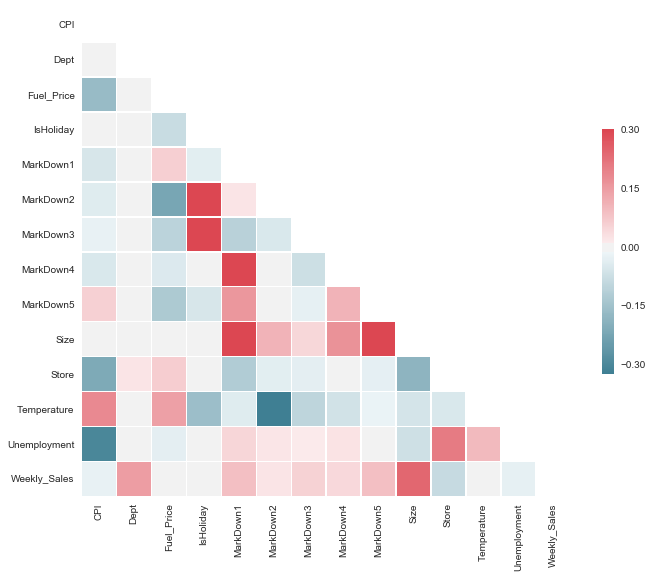

In [79]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

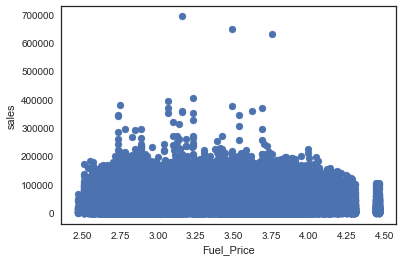

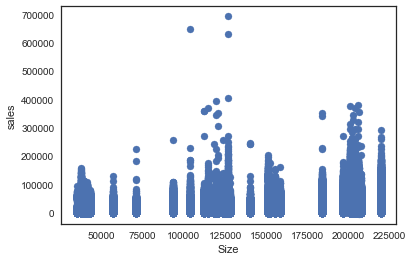

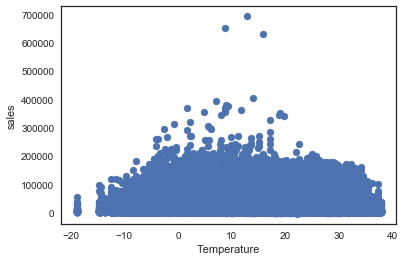

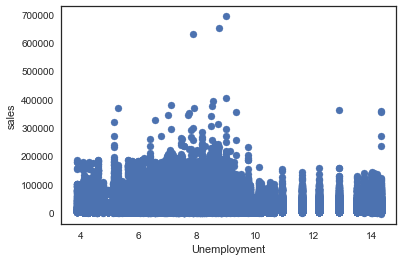

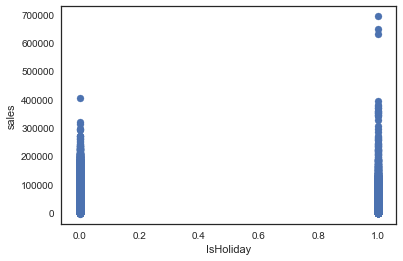

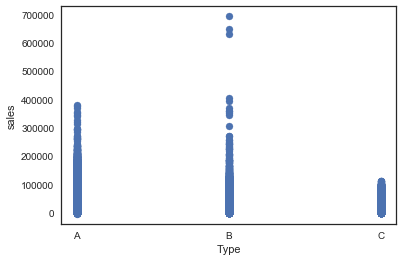

In [80]:
%matplotlib inline

headers = list(df)
labels = headers
scatterplots(df['Fuel_Price'], 'Fuel_Price')
scatterplots(df['Size'], 'Size')
scatterplots(df['Temperature'], 'Temperature')
scatterplots(df['Unemployment'], 'Unemployment')
scatterplots(df['IsHoliday'], 'IsHoliday')
scatterplots(df['Type'], 'Type')

In [81]:
df.loc[df['Weekly_Sales'] >300000]

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Split,Store,Temperature,Type,Unemployment,Weekly_Sales
29352,132.836933,2010-11-26,72,3.070,True,NaN,NaN,NaN,NaN,NaN,114533,Train,23,1.638889,B,5.287,369830.98
41292,210.515277,2010-11-26,72,2.735,True,NaN,NaN,NaN,NaN,NaN,184109,Train,39,19.861111,A,8.476,339700.62
66187,132.836933,2010-11-26,72,3.070,True,NaN,NaN,NaN,NaN,NaN,120653,Train,18,4.894444,B,9.331,353008.64
83588,129.836400,2011-11-25,72,3.760,True,174.72,329.00,141630.61,79.00,1009.98,126512,Train,10,15.933333,B,7.874,630999.19
93294,126.669267,2010-11-26,72,2.752,True,NaN,NaN,NaN,NaN,NaN,205863,Train,4,8.933333,A,7.127,381072.11
97641,126.983581,2010-12-24,72,3.236,False,NaN,NaN,NaN,NaN,NaN,126512,Train,10,13.922222,B,9.003,404245.03
116197,140.421786,2011-11-25,72,3.689,True,164.01,27.47,73934.06,24.22,540.56,204184,Train,27,8.822222,A,7.906,368484.19
121958,126.669267,2010-11-26,72,3.162,True,NaN,NaN,NaN,NaN,NaN,112238,Train,12,8.700000,B,14.313,359995.60
140076,140.421786,2011-11-25,72,3.536,True,1649.31,NaN,70087.94,7.50,5266.90,119557,Train,22,7.933333,B,7.706,345532.23
150574,136.478800,2011-11-25,72,3.536,True,748.82,46.00,71366.86,19.00,577.40,120653,Train,18,5.538889,B,8.471,305161.38


In [82]:
df.loc[df['Weekly_Sales'] >240000,"Date"].value_counts()

2011-11-25    15
2010-11-26    14
2010-12-24     8
2011-12-23     4
2010-12-17     2
2010-02-05     1
2011-08-26     1
Name: Date, dtype: int64

In [83]:
df.isnull().sum()

CPI                  0
Date                 0
Dept                 0
Fuel_Price           0
IsHoliday            0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
Size                 0
Split                0
Store                0
Temperature          0
Type                 0
Unemployment         0
Weekly_Sales    139119
dtype: int64

In [84]:
df = df.assign(md1_present = df.MarkDown1.notnull())
df = df.assign(md2_present = df.MarkDown2.notnull())
df = df.assign(md3_present = df.MarkDown3.notnull())
df = df.assign(md4_present = df.MarkDown4.notnull())
df = df.assign(md5_present = df.MarkDown5.notnull())

In [85]:
df.fillna(0, inplace=True)

In [86]:
# Make sure we can later recognize what a dummy once belonged to
df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)
df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

In [87]:
# Create dummies
type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])
holiday_dummies = pd.get_dummies(df['IsHoliday'])

In [88]:
df['DateType'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = [date.month for date in df['DateType']]
df['Month'] = 'Month_' + df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

In [89]:
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, 12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')
df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
df['Pre_christmas'] = 'Pre_christmas_' + df['Pre_christmas'].map(str)
Black_Friday_dummies = pd.get_dummies(df['Black_Friday'] )
Pre_christmas_dummies = pd.get_dummies(df['Pre_christmas'] )

In [90]:
# Add dummies
# We will actually skip some of these
#df = pd.concat([df,type_dummies,store_dummies,dept_dummies,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies,Month_dummies],axis=1)

df = pd.concat([df,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies],axis=1)

In [91]:
# Get dataframe with averages per store and department
medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median Sales
0,Type_A,Dept_1,Store_1,Month_1,IsHoliday_False,16894.400
1,Type_A,Dept_1,Store_1,Month_10,IsHoliday_False,29279.120
2,Type_A,Dept_1,Store_1,Month_11,IsHoliday_False,19300.025
3,Type_A,Dept_1,Store_1,Month_11,IsHoliday_True,19865.770
4,Type_A,Dept_1,Store_1,Month_12,IsHoliday_False,44912.860


In [92]:
# Merge by type, store, department and month
df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])


In [93]:
# Fill NA
df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True) 

# Create a key for easy access

df['Key'] = df['Type'].map(str)+df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)


In [94]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key
0,136.213613,2011-08-26,Dept_92,3.796,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262011-08-26IsHoliday_False
1,138.281452,2012-08-24,Dept_92,3.874,IsHoliday_False,4507.08,33.6,149.46,1866.46,4685.63,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262012-08-24IsHoliday_False
2,136.054032,2011-08-05,Dept_92,3.903,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262011-08-05IsHoliday_False
3,138.143774,2012-08-10,Dept_92,3.772,IsHoliday_False,5732.23,17.6,6.45,1524.63,2439.95,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262012-08-10IsHoliday_False
4,138.185710,2012-08-17,Dept_92,3.840,IsHoliday_False,2430.95,16.0,5.54,829.70,3038.77,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262012-08-17IsHoliday_False


In [141]:
# Attach variable of last weeks time
df['DateLagged'] = df['DateType']- timedelta(days=7)
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales_x,LaggedAvailable_x,Sales_dif,Difference,LaggedSales_y,LaggedAvailable_y
0,136.213613,2011-08-26,Dept_92,3.796,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,0,93212.89,Type_ADept_92Store_262011-08-26IsHoliday_False,2011-08-19,93212.89,0.0,0.0,5977.32,93212.89,0.0
1,138.281452,2012-08-24,Dept_92,3.874,IsHoliday_False,4507.08,33.6,149.46,1866.46,4685.63,...,0,93212.89,Type_ADept_92Store_262012-08-24IsHoliday_False,2012-08-17,93212.89,0.0,0.0,5067.80,93212.89,1.0
2,136.054032,2011-08-05,Dept_92,3.903,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,0,93212.89,Type_ADept_92Store_262011-08-05IsHoliday_False,2011-07-29,93212.89,0.0,0.0,-3693.64,80427.06,1.0
3,138.143774,2012-08-10,Dept_92,3.772,IsHoliday_False,5732.23,17.6,6.45,1524.63,2439.95,...,0,93212.89,Type_ADept_92Store_262012-08-10IsHoliday_False,2012-08-03,93212.89,0.0,0.0,-18599.67,93890.07,1.0
4,138.185710,2012-08-17,Dept_92,3.840,IsHoliday_False,2430.95,16.0,5.54,829.70,3038.77,...,0,93212.89,Type_ADept_92Store_262012-08-17IsHoliday_False,2012-08-10,93212.89,0.0,0.0,0.00,111812.56,1.0


In [142]:
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df.sort_values(['Store', 'Dept','DateType'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work

In [143]:
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['DateType']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.set_value(index, 'LaggedSales',last['Weekly_Sales'])
        sorted_df.set_value(index, 'LaggedAvailable',1)
    else:
        sorted_df.set_value(index, 'LaggedSales',row['Median Sales']) # Fill with median
        sorted_df.set_value(index, 'LaggedAvailable',0)

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

C:\Users\MAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

C:\Users\MAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

C:\Users\MAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

C:\Users\MAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



0% loaded
10% loaded
20% loaded
30% loaded
40% loaded
50% loaded
60% loaded
70% loaded
80% loaded
90% loaded


In [144]:
sorted_df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,20124.22,0.00,20124.220
1,Dept_1,Store_1,2010-02-12,41513.99,46039.49,41513.990
2,Dept_1,Store_1,2010-02-19,46039.49,0.00,20124.220
3,Dept_1,Store_1,2010-02-26,20124.22,19403.54,20124.220
4,Dept_1,Store_1,2010-03-05,19403.54,21827.90,20962.245


In [145]:
# Merge by store and department
df = df.merge(sorted_df[['Dept', 'Store','DateType','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','DateType'])

In [146]:
df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_92,Store_26,2011-08-26,93212.89,87235.57,93212.89
1,Dept_92,Store_26,2012-08-24,93212.89,88145.09,93212.89
2,Dept_92,Store_26,2011-08-05,80427.06,96906.53,93212.89
3,Dept_92,Store_26,2012-08-10,93890.07,111812.56,93212.89
4,Dept_92,Store_26,2012-08-17,111812.56,93212.89,93212.89


In [147]:
switch= 1

if(switch):
    df_backup = df
else:
    df=df_backup
    display(df_backup.head())

In [148]:
#df['Unemployment'] = (df['Unemployment'] - df['Unemployment'].mean())/(df['Unemployment'].std())
##df['Temperature'] = (df['Temperature'] - df['Temperature'].mean())/(df['Temperature'].std())
#df['Fuel_Price'] = (df['Fuel_Price'] - df['Fuel_Price'].mean())/(df['Fuel_Price'].std())
#df['CPI'] = (df['CPI'] - df['CPI'].mean())/(df['CPI'].std())
#df['MarkDown1'] = (df['MarkDown1'] - df['MarkDown1'].mean())/(df['MarkDown1'].std())
#df['MarkDown2'] = (df['MarkDown2'] - df['MarkDown2'].mean())/(df['MarkDown2'].std())
#df['MarkDown3'] = (df['MarkDown3'] - df['MarkDown3'].mean())/(df['MarkDown3'].std())
#df['MarkDown4'] = (df['MarkDown4'] - df['MarkDown4'].mean())/(df['MarkDown4'].std())
#df['MarkDown5'] = (df['MarkDown5'] - df['MarkDown5'].mean())/(df['MarkDown5'].std())
#df['LaggedSales']= (df['LaggedSales'] - df['LaggedSales'].mean())/(df['LaggedSales'].std())

In [149]:
df['Difference'] = df['Median Sales'] - df['Weekly_Sales']

In [150]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Key,DateLagged,LaggedSales_x,LaggedAvailable_x,Sales_dif,Difference,LaggedSales_y,LaggedAvailable_y,LaggedSales,LaggedAvailable
0,136.213613,2011-08-26,Dept_92,3.796,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,Type_ADept_92Store_262011-08-26IsHoliday_False,2011-08-19,93212.89,0.0,0.00,5977.32,93212.89,0.0,93212.89,0.0
1,138.281452,2012-08-24,Dept_92,3.874,IsHoliday_False,4507.08,33.6,149.46,1866.46,4685.63,...,Type_ADept_92Store_262012-08-24IsHoliday_False,2012-08-17,93212.89,0.0,0.00,5067.80,93212.89,1.0,93212.89,1.0
2,136.054032,2011-08-05,Dept_92,3.903,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,Type_ADept_92Store_262011-08-05IsHoliday_False,2011-07-29,93212.89,0.0,12785.83,-3693.64,80427.06,1.0,80427.06,1.0
3,138.143774,2012-08-10,Dept_92,3.772,IsHoliday_False,5732.23,17.6,6.45,1524.63,2439.95,...,Type_ADept_92Store_262012-08-10IsHoliday_False,2012-08-03,93212.89,0.0,-677.18,-18599.67,93890.07,1.0,93890.07,1.0
4,138.185710,2012-08-17,Dept_92,3.840,IsHoliday_False,2430.95,16.0,5.54,829.70,3038.77,...,Type_ADept_92Store_262012-08-17IsHoliday_False,2012-08-10,93212.89,0.0,-18599.67,0.00,111812.56,1.0,111812.56,1.0


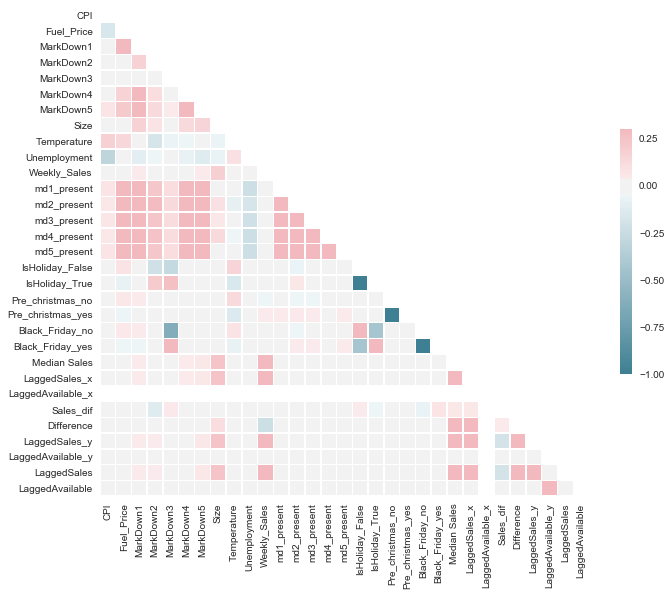

In [151]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [152]:
selector = [
    #'Month',
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment',
    
    
    
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',

    'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
display(df[selector].describe())
display(df[selector].head())

,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,171.201947,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,136727.915739,15.605588,7.960289,0.929642,0.070358,0.985808,0.014192,0.985865,0.014135,15907.380029,-179.734399,0.655172
std,39.159276,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,60980.583328,10.248851,1.863296,0.255750,0.255750,0.118283,0.118283,0.118049,0.118049,22521.689433,5538.988872,0.475313
min,126.064000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,34875.000000,-18.922222,3.879000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1750.000000,-526108.280000,0.000000
25%,132.022667,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,93638.000000,8.155556,6.891000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2114.310000,-118.608750,0.000000
50%,182.318780,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,140167.000000,16.716667,7.866000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7583.440000,0.000000,1.000000
75%,212.416993,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,202505.000000,23.488889,8.572000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,20107.905000,114.821250,1.000000
max,227.232807,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,219622.000000,37.855556,14.313000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,693099.360000,557005.550000,1.000000


,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,136.213613,3.796,0.00,0.0,0.00,0.00,0.00,152513,16.166667,7.767,...,False,1,0,1,0,1,0,93212.89,0.00,0.0
1,138.281452,3.874,4507.08,33.6,149.46,1866.46,4685.63,152513,16.711111,7.405,...,True,1,0,1,0,1,0,93212.89,0.00,1.0
2,136.054032,3.903,0.00,0.0,0.00,0.00,0.00,152513,17.311111,7.767,...,False,1,0,1,0,1,0,80427.06,12785.83,1.0
3,138.143774,3.772,5732.23,17.6,6.45,1524.63,2439.95,152513,19.450000,7.405,...,True,1,0,1,0,1,0,93890.07,-677.18,1.0
4,138.185710,3.840,2430.95,16.0,5.54,829.70,3038.77,152513,18.633333,7.405,...,True,1,0,1,0,1,0,111812.56,-18599.67,1.0


In [153]:
train = df.loc[df['Split']=='Train']
test = df.loc[df['Split']=='Test']
test.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Key,DateLagged,LaggedSales_x,LaggedAvailable_x,Sales_dif,Difference,LaggedSales_y,LaggedAvailable_y,LaggedSales,LaggedAvailable
7,132.661613,2010-08-20,Dept_92,2.796,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Type_ADept_92Store_262010-08-20IsHoliday_False,2010-08-13,93212.89,0.0,12714.41,93212.89,80498.48,1.0,80498.48,1.0
8,136.144129,2011-08-12,Dept_92,3.880,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Type_ADept_92Store_262011-08-12IsHoliday_False,2011-08-05,93212.89,0.0,-3693.64,93212.89,96906.53,1.0,96906.53,1.0
9,132.614193,2010-08-06,Dept_92,2.792,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Type_ADept_92Store_262010-08-06IsHoliday_False,2010-07-30,93212.89,0.0,0.00,93212.89,93212.89,0.0,93212.89,0.0
10,132.693226,2010-08-27,Dept_92,2.770,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Type_ADept_92Store_262010-08-27IsHoliday_False,2010-08-20,93212.89,0.0,0.00,93212.89,93212.89,0.0,93212.89,0.0
11,136.183129,2011-08-19,Dept_92,3.820,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Type_ADept_92Store_262011-08-19IsHoliday_False,2011-08-12,93212.89,0.0,0.00,93212.89,93212.89,0.0,93212.89,0.0


In [154]:
# Set seed for reproducability 
np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Difference'], test_size=0.2, random_state=42)
print(X_dev.shape)
print(y_dev.shape)

(56491, 24)
(56491,)


In [155]:
X_train.shape[1]

24

56491/56491 [==============================] - 1s 23us/step


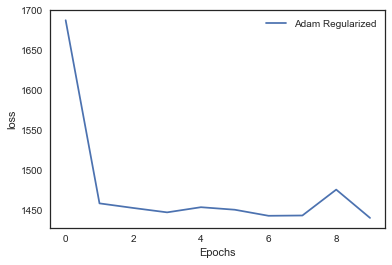

In [156]:
neural = True
if neural:
    # Sequential model
    
    adam_regularized = Sequential()

    # First hidden layer now regularized
    adam_regularized.add(Dense(32,activation='relu',
                    input_dim=X_train.shape[1],
                    kernel_regularizer = regularizers.l2(0.01)))

    # Second hidden layer now regularized
    adam_regularized.add(Dense(16,activation='relu',
                       kernel_regularizer = regularizers.l2(0.01)))

    # Output layer stayed sigmoid
    adam_regularized.add(Dense(1,activation='linear'))

    # Setup adam optimizer
    adam_optimizer=keras.optimizers.Adam(lr=0.01,
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-08)

    # Compile the model
    adam_regularized.compile(optimizer=adam_optimizer,
                  loss='mean_absolute_error',
                  metrics=['acc'])

    # Train 
    history_adam_regularized=adam_regularized.fit(X_train, y_train, # Train on training set
                                 epochs=100, # We will train over 1,000 epochs
                                 batch_size=2048, # Batch size 
                                 verbose=0) # Suppress Keras output
    adam_regularized.evaluate(x=X_dev,y=y_dev)

    # Plot network
    plt.plot(history_adam_regularized.history['loss'], label='Adam Regularized')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    y_pred_neural = adam_regularized.predict(X_dev)

In [157]:
#Random forest model specification
regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

#Train on data
regr.fit(X_train, y_train.ravel())

building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [158]:
y_pred_random = regr.predict(X_dev)

y_dev = y_dev.to_frame()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished


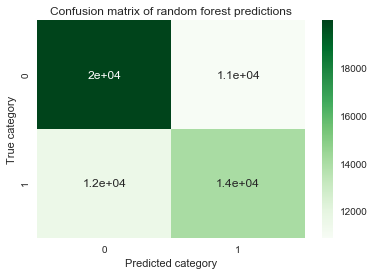

In [159]:
# Transform forest predictions to observe direction of change
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

## show confusion matrix random forest
cnf_matrix = confusion_matrix(direction_true1, direction_predict)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of random forest predictions')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();

In [160]:
y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,DateLagged,LaggedSales_x,LaggedAvailable_x,Sales_dif,Difference,LaggedSales_y,LaggedAvailable_y,LaggedSales,LaggedAvailable,Predicted
6,132.630000,2010-08-13,Dept_92,2.810,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,2010-08-06,93212.890,0.0,0.000,12714.410,93212.890,0.0,93212.890,0.0,818.78150
17,126.606645,2010-03-19,Dept_22,2.743,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,2010-03-12,6325.505,0.0,0.000,625.475,6325.505,0.0,6325.505,0.0,-166.71100
18,130.896645,2012-03-23,Dept_22,3.759,IsHoliday_False,3662.39,107.42,0.59,941.47,1934.93,...,2012-03-16,6325.505,0.0,0.000,296.905,6325.505,0.0,6325.505,0.0,385.33875
27,211.064660,2010-12-24,Dept_28,2.886,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,2010-12-17,1340.680,0.0,-218.970,-341.880,1559.650,1.0,1559.650,1.0,-272.44300
35,226.161598,2012-09-14,Dept_9,3.717,IsHoliday_False,4678.98,0.00,12.29,1130.96,5427.34,...,2012-09-07,13385.715,0.0,-10532.375,-2654.665,23918.090,1.0,23918.090,1.0,-6339.50300


In [190]:
y_dev['Predicted1'] = y_pred_neural
df_out = pd.merge(train,y_dev[['Predicted1']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted1'])]
df_out.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,DateLagged,LaggedSales_x,LaggedAvailable_x,Sales_dif,Difference,LaggedSales_y,LaggedAvailable_y,LaggedSales,LaggedAvailable,Predicted1
6,132.630000,2010-08-13,Dept_92,2.810,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,2010-08-06,93212.890,0.0,0.000,12714.410,93212.890,0.0,93212.890,0.0,274.460480
17,126.606645,2010-03-19,Dept_22,2.743,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,2010-03-12,6325.505,0.0,0.000,625.475,6325.505,0.0,6325.505,0.0,17.326830
18,130.896645,2012-03-23,Dept_22,3.759,IsHoliday_False,3662.39,107.42,0.59,941.47,1934.93,...,2012-03-16,6325.505,0.0,0.000,296.905,6325.505,0.0,6325.505,0.0,-2.451111
27,211.064660,2010-12-24,Dept_28,2.886,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,2010-12-17,1340.680,0.0,-218.970,-341.880,1559.650,1.0,1559.650,1.0,-38.817200
35,226.161598,2012-09-14,Dept_9,3.717,IsHoliday_False,4678.98,0.00,12.29,1130.96,5427.34,...,2012-09-07,13385.715,0.0,-10532.375,-2654.665,23918.090,1.0,23918.090,1.0,-1494.067627


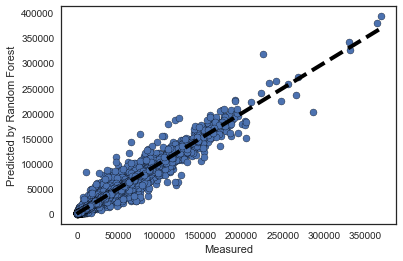

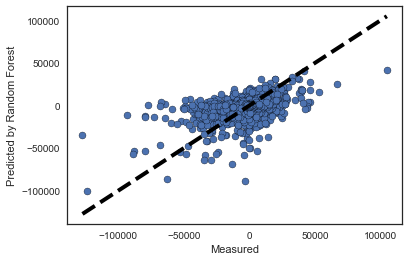

In [161]:
df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction'],"Random Forest")
plot_prediction(y_pred_random,y_dev['Difference'].values,"Random Forest")

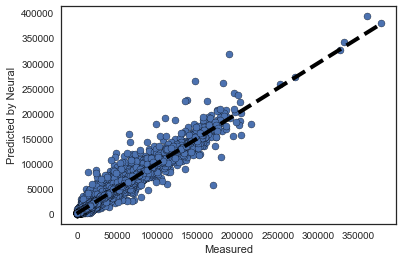

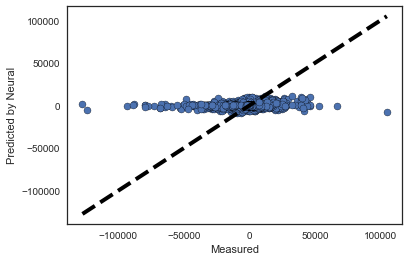

In [192]:
df_out['prediction1'] = df_out['Median Sales']-df_out['Predicted1']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction1'],"Neural")
plot_prediction(y_pred_neural,y_dev['Difference'].values,"Neural")

In [162]:
print("Medians: "+str(sum(abs(df_out['Difference']))/df_out.shape[0]))
print("Random Forest: "+str(sum(abs(df_out['Weekly_Sales']-df_out['prediction']))/df_out.shape[0]))

Medians: 1470.8708814678441
Random Forest: 1447.5117738135277


In [193]:
print("Medians: "+str(sum(abs(df_out['Difference']))/df_out.shape[0]))
print("Neural: "+str(sum(abs(df_out['Weekly_Sales']-df_out['prediction1']))/df_out.shape[0]))

Medians: 1470.8708814678441
Neural: 1442.9041167205085


In [163]:
#Random forest model specification. Set n_estimators lower for faster performance
rf_model = RandomForestRegressor(n_estimators=80, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=0, warm_start=False)

#Train on data
rf_model.fit(train[selector], train['Difference'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [164]:
final_y_prediction = rf_model.predict(test[selector])

In [165]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,LaggedSales_x,LaggedAvailable_x,Sales_dif,Difference,LaggedSales_y,LaggedAvailable_y,LaggedSales,LaggedAvailable,0,prediction
0,132.661613,2010-08-20,Dept_92,2.796,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,93212.89,0.0,12714.41,93212.89,80498.48,1.0,80498.48,1.0,8132.109938,85080.780062
1,136.144129,2011-08-12,Dept_92,3.880,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,93212.89,0.0,-3693.64,93212.89,96906.53,1.0,96906.53,1.0,-149.801375,93362.691375
2,132.614193,2010-08-06,Dept_92,2.792,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,93212.89,0.0,0.00,93212.89,93212.89,0.0,93212.89,0.0,2375.825250,90837.064750
3,132.693226,2010-08-27,Dept_92,2.770,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,93212.89,0.0,0.00,93212.89,93212.89,0.0,93212.89,0.0,1218.543750,91994.346250
4,136.183129,2011-08-19,Dept_92,3.820,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,93212.89,0.0,0.00,93212.89,93212.89,0.0,93212.89,0.0,3667.006437,89545.883563


In [166]:
output_file = pd.DataFrame({'id':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Dept']]).map(str)  + '_' +
                           testfile['Date'].map(str),
                          'Weekly_Sales':testfile['prediction']})
output_file.head()

,id,Weekly_Sales
0,26_92_2010-08-20,85080.780062
1,26_92_2011-08-12,93362.691375
2,26_92_2010-08-06,90837.064750
3,26_92_2010-08-27,91994.346250
4,26_92_2011-08-19,89545.883563


Check submission one more time

In [172]:
output_file.to_csv('submission.csv',index=False)

In [167]:
final_y_prediction1 = adam_regularized.predict(test[selector])

In [168]:
testfile1 = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction1)], axis=1)
testfile1['prediction'] = testfile1['Median Sales']-testfile1[0]
testfile1.head(10)

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,LaggedSales_x,LaggedAvailable_x,Sales_dif,Difference,LaggedSales_y,LaggedAvailable_y,LaggedSales,LaggedAvailable,0,prediction
0,132.661613,2010-08-20,Dept_92,2.796,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,93212.890,0.0,12714.410,93212.890,80498.480,1.0,80498.480,1.0,3408.066406,89804.823594
1,136.144129,2011-08-12,Dept_92,3.880,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,93212.890,0.0,-3693.640,93212.890,96906.530,1.0,96906.530,1.0,-537.399109,93750.289109
2,132.614193,2010-08-06,Dept_92,2.792,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,93212.890,0.0,0.000,93212.890,93212.890,0.0,93212.890,0.0,274.504639,92938.385361
3,132.693226,2010-08-27,Dept_92,2.770,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,93212.890,0.0,0.000,93212.890,93212.890,0.0,93212.890,0.0,274.319580,92938.570420
4,136.183129,2011-08-19,Dept_92,3.820,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,93212.890,0.0,0.000,93212.890,93212.890,0.0,93212.890,0.0,274.382019,92938.507981
5,138.377194,2012-08-31,Dept_92,3.884,IsHoliday_False,13118.17,3.40,86.31,2176.09,2555.38,...,93212.890,0.0,5067.800,93212.890,88145.090,1.0,88145.090,1.0,187.374512,93025.515488
6,130.967097,2012-03-30,Dept_22,3.820,IsHoliday_False,7866.57,104.84,5.59,28.76,1979.96,...,6325.505,0.0,296.905,6325.505,6028.600,1.0,6028.600,1.0,90.229797,6235.275203
7,130.741379,2012-03-09,Dept_22,3.667,IsHoliday_False,6150.33,209.07,0.00,124.83,4638.14,...,6325.505,0.0,-928.975,6325.505,7254.480,1.0,7254.480,1.0,-213.256531,6538.761531
8,126.604286,2010-03-12,Dept_22,2.704,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,6325.505,0.0,-1502.485,6325.505,7827.990,1.0,7827.990,1.0,-297.351624,6622.856624
9,130.826194,2012-03-16,Dept_22,3.707,IsHoliday_False,6104.24,94.31,2.70,479.70,1656.98,...,6325.505,0.0,0.000,6325.505,6325.505,0.0,6325.505,0.0,9.341370,6316.163630


In [170]:
output_file1 = pd.DataFrame({'id':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile1['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile1['Dept']]).map(str)  + '_' +
                           testfile1['Date'].map(str),
                          'Weekly_Sales':testfile1['prediction']})
output_file1.head()

,id,Weekly_Sales
0,26_92_2010-08-20,89804.823594
1,26_92_2011-08-12,93750.289109
2,26_92_2010-08-06,92938.385361
3,26_92_2010-08-27,92938.570420
4,26_92_2011-08-19,92938.507981


In [171]:
output_file.to_csv('submission(neural_regularized).csv',index=False)